### Train model

Dataset 
16840 entries of business news

in 5 categories by how negative/positive for given entity

Entity is a company name, with given location within text. Can be several entities in single article.

headline is also given.

In [ ]:
import json
import ast
import pandas as pd
import html
import numpy as np
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../fastaiDL/fastai/courses/dl2")
from fastai.text import *

In [2]:
import fastai
print(getattr(fastai, '__version__', 0.6))

0.6


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA = 'data/'
file = 'polarity_data.js' # business news
datafile = DATA+file

LM_PATH=Path('work/lm/')
LM_PATH.mkdir(exist_ok=True)
CLAS_PATH=Path('work/clas/')
CLAS_PATH.mkdir(exist_ok=True)
PATH=Path('.')
CLASSES = ['veryneg', 'neg', 'neut', 'pos', 'very pos']

#tags
XBOB = ' xbob ' # beginning-of-body tag
#ENTBEG = 'xentb '  # beginning-of-entity in text
#ENTEND = ' xente'  # end of entity in text
ENT =  'ENTITY '   # replace target entity in the text

# '_entity_' ended up as 3 tokens '_', 'entity', '_'

with open(datafile, encoding='utf-8') as data_file:
    data = ast.literal_eval(data_file.read())
df = pd.DataFrame.from_dict(data, orient='columns')

### Randomize

### LM tokenize

In [5]:
clas_file = 15718 # by maxsize, see filename in PATH CLAS_PATH if need
lm_file = 14840

trainfile =   'train'+str(lm_file)+'.csv'
testfile  = 'test_of'+str(lm_file)+'.csv'

chunksize=24000
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [6]:
df_train = pd.read_csv(LM_PATH/trainfile, header=None, chunksize=chunksize)
df_validate = pd.read_csv(LM_PATH/testfile, header=None, chunksize=chunksize)

In [7]:
import re, html
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        #'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        # '\n' replaced with ' '
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', ' ').replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [8]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [9]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [10]:
tok_train, trn_labels = get_all(df_train, 1)
tok_validate, val_labels = get_all(df_validate, 1)

0
0


In [11]:
np.save(LM_PATH/'tmp'/'tok_train.npy', tok_train)
np.save(LM_PATH/'tmp'/'tok_validate.npy', tok_validate)

In [12]:
tok_train = np.load(LM_PATH/'tmp'/'tok_train.npy')
tok_validate = np.load(LM_PATH/'tmp'/'tok_validate.npy')

In [13]:
freq = Counter(p for o in tok_train for p in o)
freq.most_common(25)

[('the', 349664),
 (',', 294419),
 ('.', 287418),
 ('\n', 182449),
 ('to', 181482),
 ('of', 153664),
 ('and', 144620),
 ('in', 143840),
 ('a', 134955),
 ('-', 79642),
 ('t_up', 77125),
 ('for', 66610),
 ('that', 60775),
 ('on', 59742),
 ('$', 53449),
 ('is', 53366),
 ('it', 48670),
 ('"', 46549),
 ('its', 46457),
 ('with', 43788),
 ("'s", 41296),
 ('said', 41261),
 ('company', 39228),
 ('as', 37325),
 ('by', 36956)]

In [14]:
max_vocab = 60000
min_freq = 2

In [15]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

#itos.insert(0, '_pad_')
itos.insert(0, '<unk>')

# WAS it <unk> in the data, not _unk_?

In [16]:
# insert for ENTITY (target entity)
itos.insert(0, 'ENTITY')

In [17]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

34915

In [18]:
train_lm = np.array([[stoi[o] for o in p] for p in tok_train])
validate_lm = np.array([[stoi[o] for o in p] for p in tok_validate])

In [19]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', train_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', validate_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [20]:
# EXTRA
# STORE THIS! Needed for prediction
pickle.dump(itos, open(LM_PATH/'tmp'/'itosMax.pkl', 'wb'))

In [24]:
train_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
validate_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [25]:
vocsize=len(itos)
vocsize,len(train_lm)

(34915, 14840)

In [26]:
len(tok_train)

14840

### Wikitext-103 conversion

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. Link to dataset The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: Link. Our target LM is the IMDB LM. 

In [27]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values with the target IMDB LM so that the weights can be loaded up.

In [28]:
emb_size,nhiddenu,nlayers = 400,1150,3

In [29]:
PATH=Path('.')
PATH

PosixPath('.')

In [30]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [31]:
#PRE_PATH = 'models/wt103'
#PRE_LM_PATH = 'models/wt103/fwd_wt103.h5'

In [32]:
PRE_LM_PATH

PosixPath('models/wt103/fwd_wt103.h5')

In [33]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [34]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [35]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [36]:
new_w = np.zeros((vocsize, emb_size), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [37]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [38]:
# only extra print info
# Signature: T(a, half=False, cuda=True)
# Docstring: Convert numpy array into a pytorch tensor

a = wgts['0.encoder.weight']
type(a)

torch.cuda.FloatTensor

### Language model

In [39]:
wd=1e-7 #weight decay
bptt=70 # back propagation through time
# was 52 but out of GPU mem
# with 32 seems to use 7,36 GB 
# bs=32
#bs = 25
#bs = 52 # batch size
bs=72
bs=100
bs=32
optim_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the LanguageModelLoader to create a data loader which makes it easy to create and use bptt sized mini batches. The LanguageModelLoader takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called LanguageModelData to which we can pass the training and validation loaders and get in return the model itself.


In [40]:
train_dataloader = LanguageModelLoader(np.concatenate(train_lm), bs, bptt)
validate_dataloader = LanguageModelLoader(np.concatenate(validate_lm), bs, bptt)
model = LanguageModelData(PATH, 1, vocsize, train_dataloader, validate_dataloader, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. No other dropout value requires tuning

In [41]:
# dropouts
#drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.8

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [42]:
learner= model.get_model(optim_fn, emb_size, nhiddenu, nlayers, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [43]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our OWN LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [44]:
lr=1e-3
lrs = lr

In [45]:
bs=140
# LM 140 is ok, 200 is oom (full length LM-articles)
# bs 140, 8k truncated 6659 MB -> up to 6965 when proceeding

# expected
# learner.fit  0.317314
# lr_find 0.355

In [46]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.453638   4.120457   0.300652  



[array([4.12046]), 0.3006517675098957]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).


In [61]:
learner.save('lm_last-ent_ft')

In [62]:
learner.load('lm_last-ent_ft')

In [63]:
learner.unfreeze()

In [64]:
#bs=140

In [65]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.095493   3.788278   0.338212  



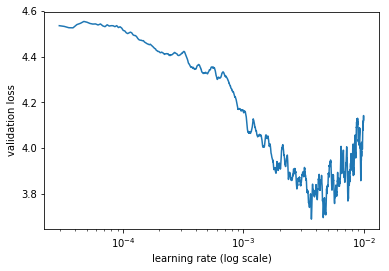

In [66]:
learner.sched.plot()

In [67]:
lrs

0.001

In [68]:
bs=140
lrs =1e-3
learner.fit(lrs, n_cycle=1, wds=wd, use_clr=(20,10), cycle_len=20)

epoch      trn_loss   val_loss   accuracy                     
    0      3.635672   3.312772   0.395224  
    1      3.220798   2.92392    0.449953                     
    2      2.997155   2.690247   0.488311                     
    3      2.810141   2.549778   0.513016                     
    4      2.687036   2.458257   0.530001                     
    5      2.626963   2.389082   0.544225                     
    6      2.553965   2.338485   0.554421                     
    7      2.611864   2.292894   0.561937                     
    8      2.440274   2.256401   0.569852                     
    9      2.43019    2.224718   0.576048                     
    10     2.392038   2.202989   0.580578                     
    11     2.383107   2.172906   0.58659                      
    12     2.276034   2.15677    0.591451                     
    13     2.305274   2.136978   0.594777                     
    14     2.228293   2.121025   0.598528                     
    15     

[array([2.06921]), 0.6101147709810227]

In [165]:
# after splitting entities, first main try, .59+ is goal, data randomized, entities not marked in LM
# 20 reaches 0.57 and still increasing fast 0.57 to 0.574
# batchsize 200 worked for 4k truncated
bs=140 
lrs =5e-3
learner.fit(lrs, n_cycle=1, wds=wd, use_clr=(20,10), cycle_len=20)

epoch      trn_loss   val_loss   accuracy                     
    0      3.451486   3.219849   0.406877  
    1      3.476988   3.22243    0.406604                     
    2      3.365643   3.12433    0.421181                     
    3      3.204469   3.02028    0.436237                     
    4      3.136014   2.944028   0.448716                     
    5      3.074043   2.873266   0.461102                     
    6      2.972078   2.798478   0.473559                     
    7      2.865905   2.739218   0.483731                     
    8      2.770412   2.683193   0.493587                     
    9      2.79299    2.627315   0.503411                     
    10     2.651105   2.577286   0.51316                      
    11     2.57571    2.531726   0.521849                     
    12     2.517409   2.488049   0.529755                     
    13     2.456295   2.446648   0.538016                     
    14     2.480263   2.408098   0.545173                     
    15     

[array([2.26276]), 0.5748678171737294]

In [ ]:
# after splitting entities, first main try, .59+ is goal
lrs =5e-3
learner.fit(lrs, n_cycle=1, wds=wd, use_clr=(20,10), cycle_len=20)

In [82]:
# trunc 4k, maybe not good, repeating same data instead of new
.learner.fit(lrs, n_cycle=1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      3.574274   3.2758     0.399256  
    1      3.500602   3.235741   0.404575                     
    2      3.353847   3.093312   0.425605                     
    3      3.221653   2.985482   0.442458                     
    4      3.124829   2.893923   0.456953                     
    5      3.026518   2.815494   0.469902                     
    6      2.926473   2.736441   0.483996                     
    7      2.852153   2.670463   0.496062                     
    8      2.799434   2.600488   0.507748                     
    9      2.706199   2.541887   0.518628                     
    10     2.633005   2.487245   0.528666                     
    11     2.568277   2.439431   0.538178                     
    12     2.492155   2.39227    0.547058                     
    13     2.427679   2.358953   0.554006                     
    14     2.39076    2.329921   0.560096                     



[array([2.32992]), 0.5600963007129652]

In [69]:
learner.save('lm1-full-noent-061')

In [70]:
learner.save_encoder('lm1-full-noent061_enc')

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [83]:
#learner.save('lm1-trunc4k12k-ent')

In [84]:
#learner.save_encoder('lm1-trunc4k12k-ent_enc')

Text(0,0.5,'Accuracy')

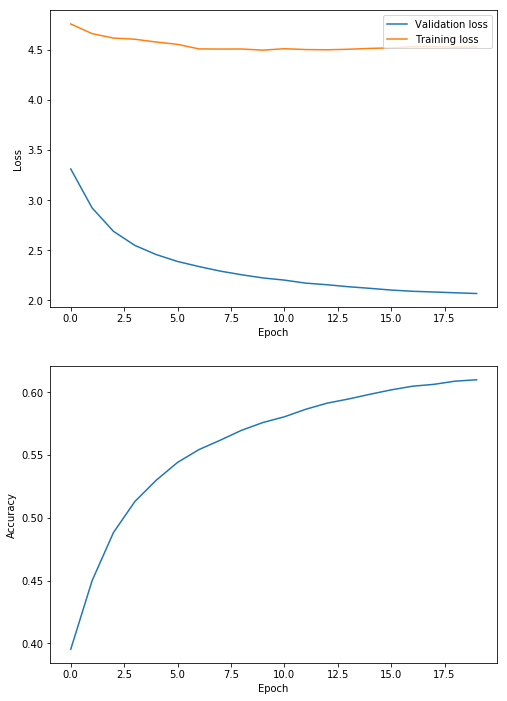

In [71]:
epochs = len(learner.sched.val_losses)
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(epochs)),learner.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(epochs)),[learner.sched.losses[i] for i in range(epochs)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

ax[1].plot(list(range(epochs)),learner.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

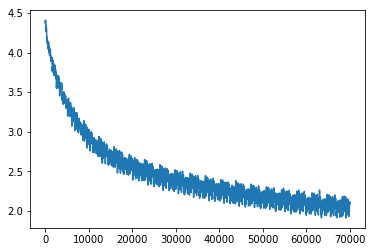

In [57]:
learner.sched.plot_loss()

### Classifier Tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.


trainsize = 12000
devsize = 3000
trainfile = 'train'+str(trainsize)+'.csv'
devfile = 'test'+str(devsize)+'.csv'



In [11]:
# extra if start here
chunksize=24000
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [10]:
# fix for filename to save
trainsize = 15718

In [11]:
# clasfile len = 15718
trainfile = 'train15718entity.csv'
devfile = 'test_of15718entity.csv'

df_train = pd.read_csv(CLAS_PATH/trainfile, header=None, chunksize=chunksize)
df_validate = pd.read_csv(CLAS_PATH/devfile, header=None, chunksize=chunksize)

In [12]:
df_train

In [13]:
tok_train, train_labels = get_all(df_train, 1)
tok_validate, validate_labels = get_all(df_validate, 1)

0
0


In [14]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_train)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_validate)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', train_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', validate_labels)

In [15]:
tok_train = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_validate = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [16]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

34915

In [17]:
train_clas = np.array([[stoi[o] for o in p] for p in tok_train])
validate_clas = np.array([[stoi[o] for o in p] for p in tok_validate])

In [18]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', train_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', validate_clas)

In [19]:
type(train_labels)

list

In [20]:
train_labels[0:4]

[array([3]), array([0]), array([0]), array([1])]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41025a6fd0>]], dtype=object)

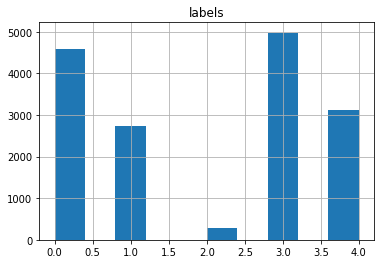

In [21]:
#train_labels
#hist(train_labels

histog = pd.DataFrame({'labels': train_labels})
# unpack
histog['labels'] = histog.apply(lambda row: row['labels'][0], axis=1)
histog.hist(column='labels')

### Create classifier

In [22]:
train_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
validate_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [23]:
train_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
validate_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

#### optional - turn into BINARY CLASSIFICATION

In [68]:
# negative vs positive + neutra  
# 0 and 1 -> 0
# 2,3 and 4 -> 1

binary_train_labels = [0 if (x==0 or x==1) else 1 for x in train_labels]
binary_validate_labels = [0 if (x==0 or x==1) else 1 for x in validate_labels]

# remember to do same for test set.

In [ ]:
binary_train_labels

#### Optional - truncate documents

In [24]:
trun_len = 80  #words
trun_len = 200

for i in range(len(train_clas)):
    train_clas[i] = train_clas[i][0:trun_len]
    
for i in range(len(validate_clas)):
    validate_clas[i] = validate_clas[i][0:trun_len]
    
assert len(train_clas[0]) == trun_len
assert len(validate_clas[0]) == trun_len

In [25]:
bptt,emb_size,nhiddenu,nlayers = 70,400,1150,3
vocsize = len(itos)
optim_fn = partial(optim.Adam, betas=(0.8, 0.99))
#bs = 26
#bs = 32  # 7175 MB memory usage on business news data at final training, this with 13k length articles
# 32 too high
bs = 14

In [26]:
bs=12
bs=25

In [27]:
min_lbl = train_labels.min()
train_labels -= min_lbl
validate_labels -= min_lbl
c=int(train_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by @Smerity and @jekbradbury

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.


In [28]:
train_ds = TextDataset(train_clas, train_labels)
validate_ds = TextDataset(validate_clas, validate_labels)
train_samp = SortishSampler(train_clas, key=lambda x: len(train_clas[x]), bs=bs//2)
validate_samp = SortSampler(validate_clas, key=lambda x: len(validate_clas[x]))
train_dl = DataLoader(train_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=train_samp)
validate_dl = DataLoader(validate_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=validate_samp)
model = ModelData(PATH, train_dl, validate_dl)

In [29]:
train_labels[0:10]

array([3, 0, 0, 1, 4, 3, 3, 1, 3, 0])

In [30]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [31]:
m = get_rnn_classifier(bptt, 20*70, c, vocsize, emb_sz=emb_size, n_hid=nhiddenu, n_layers=nlayers, pad_token=1,
          layers=[emb_size*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [32]:
optim_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [33]:
learn = RNN_Learner(model, TextModel(to_gpu(m)), opt_fn=optim_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [34]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

# THESE NOT USED, NEXT OVERWRITES

In [35]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [36]:
wd = 1e-7
wd = 0
# WEIGHT DECAY stays ALWAYS 0 this way!

#learn.load_encoder('lm1-12k-ent_enc')
#learn.load_encoder('lm1-full-noent061_enc')


In [83]:
learn.freeze_to(-1)

 78%|███████▊  | 1020/1310 [02:18<00:39,  7.35it/s, loss=5.6] 

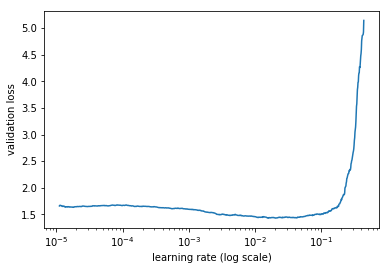

In [84]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [85]:
lrs

array([0.0001, 0.0001, 0.0001, 0.001 , 0.01  ])

In [86]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.431822   1.436869   0.315     


[array([1.43687]), 0.31499999957159164]

In [87]:
learn.save('clas_0'+'_trainsize_'+str(trainsize))

In [88]:
learn.load('clas_0'+'_trainsize_'+str(trainsize))

In [89]:
learn.freeze_to(-2)

In [90]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.415951   1.438869   0.315     


[array([1.43887]), 0.31499999957159164]

In [91]:
learn.save('clas_1'+'_trainsize_'+str(trainsize))

In [37]:
learn.load('clas_1'+'_trainsize_'+str(trainsize))

In [38]:
learn.unfreeze()

 79%|███████▉  | 1032/1310 [04:31<01:13,  3.80it/s, loss=5.04]

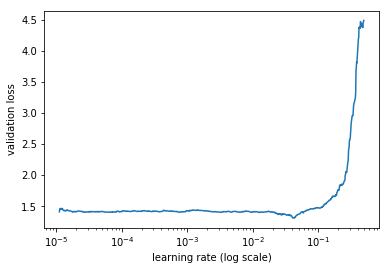

In [94]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [39]:
# 1.11 noENT on LM, ENT on clas
wd=1e-7 #1e-6?
bs=200  # try with truncated 200 words
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*1 
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*2 ?
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=20, use_clr=(10,20))

epoch      trn_loss   val_loss   accuracy                     
    0      1.025954   1.017071   0.5575    
    1      0.888767   0.772047   0.6595                        
    2      0.721386   0.673798   0.7315                        
    3      0.589075   0.677841   0.748                         
    4      0.483754   0.478499   0.8225                        
    5      0.476519   0.428138   0.845                         
    6      0.405554   0.462406   0.851                         
    7      0.324407   0.379418   0.8835                        
    8      0.319293   0.378683   0.871                         
    9      0.37745    0.3294     0.892                         
    10     0.321874   0.388887   0.8675                        
    11     0.333175   0.338951   0.8815                        
    12     0.230425   0.320582   0.8955                        
    13     0.268168   0.326834   0.894                         
    14     0.267637   0.330666   0.889                       

[array([0.31995]), 0.903499997407198]

In [112]:
# was wrong, not ENT after all in clas data!
# 1.11 noENT on LM, ENT on clas
.
wd=1e-7 #1e-6?
bs=200  # try with truncated 200 words
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*1 
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*2 ?
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=20, use_clr=(10,20))

epoch      trn_loss   val_loss   accuracy                     
    0      1.080745   1.154619   0.468     
    1      0.912616   0.827696   0.6725                        
    2      0.803956   0.725042   0.7115                        
    3      0.660619   0.666951   0.7435                        
    4      0.629606   0.552529   0.7945                        
    5      0.595529   0.518047   0.812                         
    6      0.480156   0.519156   0.8205                        
    7      0.48899    0.514283   0.8215                        
    8      0.365413   0.487099   0.83                          
    9      0.4077     0.450899   0.8265                        
    10     0.350877   0.443739   0.8295                        
    11     0.395255   0.444448   0.8315                        
    12     0.302502   0.432657   0.837                         
    13     0.317949   0.464915   0.833                         
    14     0.307394   0.449634   0.8355                      

[array([0.45314]), 0.8260000012814999]

In [95]:
# 31.10 ENT on LM, ENT on clas
wd=1e-7 #1e-6?
bs=200  # try with truncated 200 words
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*1 
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*2 ?
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=20, use_clr=(10,20))

epoch      trn_loss   val_loss   accuracy                      
    0      0.901914   0.737277   0.707     
    1      0.843598   0.689649   0.742                         
    2      0.785138   0.650254   0.7515                        
    3      0.820657   0.626869   0.7535                        
    4      0.766361   0.607883   0.773                         
    5      0.715389   0.583788   0.784                         
    6      0.781313   0.562963   0.7895                        
    7      0.755657   0.559893   0.787                         
    8      0.714867   0.550014   0.7935                        
    9      0.693643   0.525307   0.804                         
    10     0.705955   0.525282   0.804                         
    11     0.671646   0.515538   0.8095                        
    12     0.670022   0.50731    0.8145                        
    13     0.678187   0.530717   0.8155                        
    14     0.658997   0.502076   0.817                      

[array([0.49197]), 0.821500001102686]

In [246]:
# 25.10, split entities, randomized, LM has not ENT-tag. CLAS data does have.
# no trunc on LM

# 16 epoch reaches 0.84, #33 is max 0.857
wd=1e-7 #1e-6?
bs=200
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*1 
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*2 ?
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=40, use_clr=(10,40))


epoch      trn_loss   val_loss   accuracy                      
    0      0.863732   0.673801   0.726333  
    1      0.859651   0.676968   0.738333                     
    2      0.778679   0.613633   0.757333                      
    3      0.805469   0.589531   0.770333                      
    4      0.771135   0.583629   0.777                         
    5      0.690103   0.547105   0.788333                     
    6      0.668815   0.543315   0.785333                      
    7      0.64111    0.514515   0.805                         
    8      0.678837   0.516527   0.797667                      
    9      0.617058   0.486839   0.818                         
    10     0.590986   0.491506   0.818667                      
    11     0.573794   0.46893    0.821333                      
    12     0.560596   0.472524   0.827333                      
    13     0.538717   0.509057   0.819667                      
    14     0.564312   0.462762   0.830667                     

[array([0.447]), 0.8543333311875662]

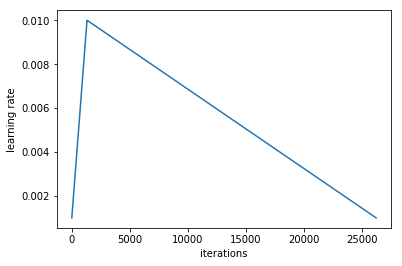

In [96]:
learn.sched.plot_lr()

In [203]:
# 1cycle
# - maximum lr from test
# - minimum as 1/10 of max
# - raising of lr to be chosen
# - often big bs and higher lr preferred

# - momentum, possible to use cyclical momentum
# Short runs with momentum values of 0.99, 0.97, 0.95, and 0.9 will quickly show the best value for momentum
# lower end: 0.8 or 0.85 (performance is almost independent of the minimum momentum value)

wd=1e-7 #1e-6?
bs=200
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*1.2 # higher!
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*2 ?
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=50, use_clr=(10,40))

epoch      trn_loss   val_loss   accuracy                    
    0      0.894836   0.727825   0.725     
    1      0.867559   0.724577   0.707                       
    2      0.874823   0.818662   0.7375                      
    3      0.810144   2.448367   0.743                       
    4      0.724066   0.737688   0.748                       
    5      0.738162   0.709561   0.7605                      
    6      0.649582   0.564669   0.7895                      
    7      0.648562   0.559181   0.796                       
    8      0.576893   0.545653   0.7945                      
    9      0.586251   0.553139   0.807                       
    10     0.566973   0.5306     0.8135                      
    11     0.58191    0.54444    0.8195                      
    12     0.509779   0.53532    0.819                       
    13     0.481554   0.522785   0.8245                      
    14     0.482669   0.586675   0.82                        
    15     0.495074   0.55

[array([0.59104]), 0.8499999923110009]

In [ ]:
learn.fit(lrs, n_cycle=4, wds=wd, cycle_len=10, use_clr=(32,10))

In [ ]:
# Best 0.85
wd=1e-7
bs=82
learn.fit(lrs, n_cycle=2, wds=wd, cycle_len=10, use_clr=(32,10))
learn.fit(lrs, n_cycle=2, wds=wd, cycle_len=10, use_clr=(32,10)) # .8425
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*0.3
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=10, use_clr=(32,10))
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=10, use_clr=(32,10))
bs = 100
learn.fit(lrs, n_cycle=1, wds=wd, cycle_len=10, use_clr=(32,10)) #.85

In [178]:
# bs 150 works, bs 200 works. 250 takes 6067 MB, 280 takes 6715 MB, 300=7,4GB, OBS later 300 gives 8095MB !! 
# variation

In [ ]:
# clr_beta_ ratio 10 for high-low lr, 15% of epochs left for after, max and min momentum.
# learn.fit(0.8, 1, cycle_len=95, use_clr_beta=(10, 13.68, 0.95, 0.85), wds=1e-4)
wd = 0
learn.fit(lrs, 1, wds=wd, cycle_len=15, use_clr_beta=(10, 15, 0.95, 0.85)) # add 0.95, 0.85 to use_clr_beta

In [40]:
learn.save('clas_2_Classifier'+'_fullLM_'+'full')

In [41]:
learn.load('clas_2_Classifier'+'_fullLM_'+'full')

In [ ]:
.learn.save('clas_2_Classifier'+'_ent_trainsize_'+str(trainsize)+'')

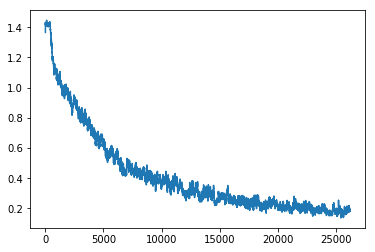

In [42]:
learn.sched.plot_loss()

In [43]:
learn.sched.nb

26200

### Predict test set

In [44]:
targetfile = 'final_test.csv'
targetfile = 'final_test15718entity.csv'
bs = 14
bs = 200

In [45]:
chunksize=24000
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
df_test = pd.read_csv(CLAS_PATH/targetfile, header=None, chunksize=chunksize)

# tokenize
tokens_test, test_labels = get_all(df_test, 1)

(CLAS_PATH/'tmp').mkdir(exist_ok=True)
np.save(CLAS_PATH/'tmp'/'tok_test.npy', tokens_test)
np.save(CLAS_PATH/'tmp'/'test_labels.npy', test_labels)

0


In [46]:
# saving and loading changes from list to np.ndarray
tokens_test = np.load(CLAS_PATH/'tmp'/'tok_test.npy')
len(tokens_test), len(test_labels)

(2000, 2000)

In [47]:
# change strings to integers
test_clas = np.array([[stoi[o] for o in p] for p in tokens_test])
test_clas = np.expand_dims(test_clas, axis=1)
np.save(CLAS_PATH/'tmp'/'test_ids.npy', test_clas)

In [48]:
test_clas = np.load(CLAS_PATH/'tmp'/'test_ids.npy')
test_clas = np.squeeze(test_clas) 
test_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'test_labels.npy'))
n_class=int(test_labels.max())+1

In [50]:
#build TextDataSet
test_dataset = TextDataset(test_clas, test_labels)

# build sortSampler - mixes labels and items, doesnt work
#test_sampler = SortSampler(test_clas, key=lambda x: len(test_clas[x]))

# build DataLoader
# shuffle mixes labels wrongly
#test_loader = DataLoader(test_dataset, bs, transpose=True, num_workers=1, pad_idx=1, sampler=test_sampler)
test_loader = DataLoader(test_dataset, bs, transpose=True, num_workers=1, pad_idx=1, 
                         sampler=None, shuffle=False)

# build TextData
# TextData or fastai.nlp were not used when training mdoel
from fastai.nlp import TextData
md = TextData(PATH, None, test_loader)

In [52]:
bs = 150 # out of memory
bs = 100 # maybe ok from empty?, but oom after training
bs = 35 # continue after training: 6,1GB usage

bptt,em_sz,nhiddenu,nlayers = 70,400,1150,3
vocsize = len(itos)
optim_fn = partial(optim.Adam, betas=(0.8, 0.99))

model = get_rnn_classifier(bptt, 20*70, n_class, vocsize, emb_sz=em_sz, n_hid=nhiddenu, n_layers=nlayers, pad_token=1,
          layers=[em_sz*3, 50, n_class], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

#model.eval  - automatically called?

learner = RNN_Learner(
    data=md,
    models=TextModel(to_gpu(model)),    
    opt_fn=optim_fn
)

In [53]:
preds_dist, true_labels = learner.predict_with_targs()

### Plot Training

In [54]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

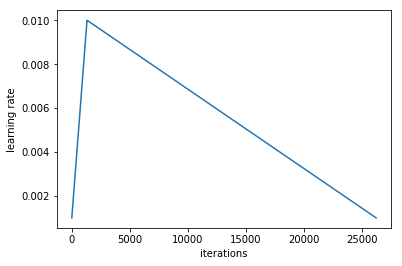

In [55]:
learn.sched.plot_lr()

In [57]:
# points from individual losess along the way. 
epochs = 20
points = list(range(epochs, len(learn.sched.losses), int(len(learn.sched.losses)/epochs)))

In [58]:


p_val_losses = learn.sched.val_losses
#p_losses = [learn.sched.losses[i] for i in range(epochs,150)]
p_losses = [learn.sched.losses[i] for i in points ]
p_rec_metrics = learn.sched.rec_metrics

In [59]:
len(learn.sched.val_losses)

20

In [60]:
learn.sched

Text(0,0.5,'Accuracy')

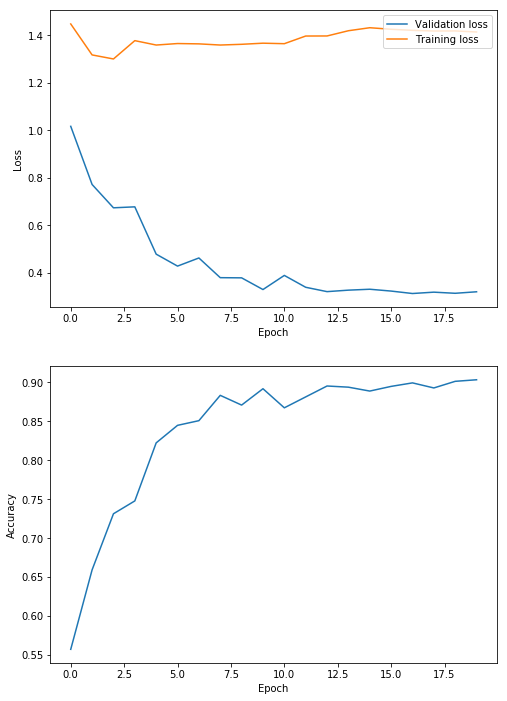

In [61]:
epochs = 20

# Losses
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(epochs)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(epochs)),[learn.sched.losses[i] for i in range(epochs)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

# Accuracy
ax[1].plot(list(range(epochs)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')


Text(0,0.5,'Accuracy')

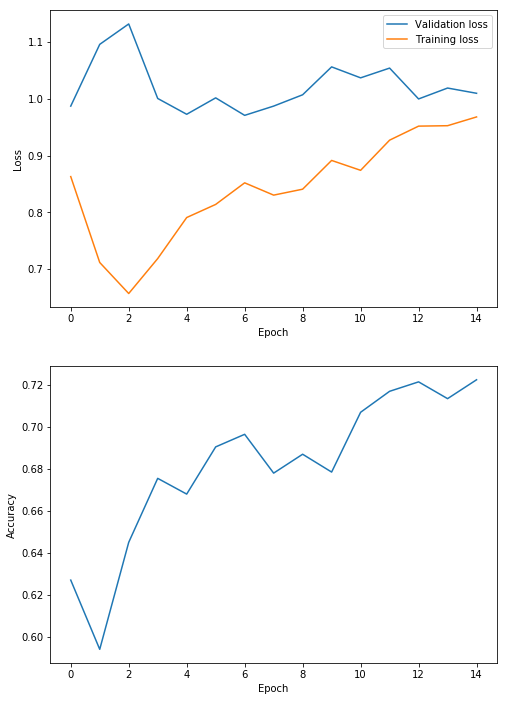

In [166]:
epochs = 15

# Losses
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(epochs)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(epochs)),[learn.sched.losses[i] for i in range(epochs)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')

# Accuracy
ax[1].plot(list(range(epochs)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')


In [95]:
epochs = 15
xvalidate_loss = learn.sched.val_losses
xtrain_loss = [learn.sched.losses[i] for i in range(epochs)]
xaccuracy = learn.sched.rec_metrics

In [96]:
trainsize

8000

In [97]:
results[trainsize]= pd.DataFrame({'val': xvalidate_loss, 'train':xtrain_loss, 'acc':xaccuracy})

In [161]:
#results1000 = pd.DataFrame({'val': xvalidate_loss, 'train':xtrain_loss, 'acc':xaccuracy})

### Results with different sized training data

In [98]:
results[8000]

,val,train,acc
0,[4.82410333840549],0.499924,0.6485
1,[0.9181957594454289],0.592864,0.7395
2,[1.155655806310475],0.605727,0.7775
3,[0.8125892618820071],0.634543,0.8100
4,[5.843671057600528],0.614488,0.7745
5,[6.287118505634368],0.622923,0.7820
6,[12.47612617594935],0.648743,0.7910
7,[111.34638942733035],0.660557,0.7775
8,[1.3332453550454229],0.660923,0.8205
9,[7.197082749731838],0.652427,0.8255


In [93]:
# Load
results = np.load('resultsx.npy').item()

In [100]:
#dictionary = {'hello':'world'}
np.save('resultsx1.npy', results) 

In [ ]:
results100.to_csv('results100.csv')

In [155]:
results100 = pd.read_csv('results100.csv')

In [149]:
results1000 = pd.DataFrame({'val': xvalidate_loss, 'train':xtrain_loss, 'acc':xaccuracy})
results1000

,val,train,acc
0,[0.9872420721650124],0.863131,0.6270
1,[1.0959983005225657],0.711867,0.5940
2,[1.1319324245899915],0.657229,0.6450
3,[1.0007186770141125],0.718754,0.6755
4,[0.9728661698848009],0.791027,0.6680
5,[1.0017748506218196],0.814120,0.6905
6,[0.9709802632331848],0.852151,0.6965
7,[0.9872805901020766],0.830495,0.6780
8,[1.007214888587594],0.840957,0.6870
9,[1.0563348397463561],0.891591,0.6785


In [102]:
results500 = pd.DataFrame({'val': xvalidate_loss, 'train':xtrain_loss, 'acc':xaccuracy})
results500

,val,train,acc
0,[1.0498955637216567],1.034174,0.5725
1,[1.1106152303516865],0.917990,0.5845
2,[1.108517288863659],0.972473,0.6020
3,[1.197882125020027],0.933784,0.5960
4,[2.1856168991476297],0.848695,0.5845
5,[3.929511443644762],0.880784,0.5810
6,[1.5566950822472572],0.871992,0.5965
7,[2.5267729723006487],0.914394,0.6080
8,[4.981768222734332],1.000357,0.6215
9,[5.416245001584292],0.948081,0.6080


In [55]:
results300 = pd.DataFrame({'val': xvalidate_loss, 'train':xtrain_loss, 'acc':xaccuracy})
results300

,val,train,acc
0,[1.148422669172287],1.120210,0.5775
1,[1.2495238498449326],0.912188,0.5135
2,[1.3291830311119557],0.922584,0.5190
3,[1.2065900976359845],0.835061,0.5440
4,[1.298182210713625],0.897600,0.5600
5,[1.3334138369262218],0.852542,0.5685
6,[1.4095449968278408],0.891998,0.5610
7,[1.5145190207064152],0.857893,0.5980
8,[1.417078743264079],0.832469,0.6000
9,[1.4897609430849552],0.833281,0.5930


In [89]:
results200 = pd.DataFrame({'val': xvalidate_loss, 'train':xtrain_loss, 'acc':xaccuracy})
results200

,val,train,acc
0,[1.195070844143629],1.041893,0.5360
1,[1.3940935591161252],1.094646,0.5690
2,[1.4975435910969972],0.992466,0.5460
3,[1.3699843916893006],0.969821,0.5745
4,[1.4847442761063576],0.998617,0.5510
5,[1.6594213886260987],0.936941,0.5570
6,[1.7852485501468183],0.986875,0.5560
7,[1.7116678630709647],0.982495,0.5495
8,[1.5778338895440103],0.975589,0.5430
9,[1.5465353992581368],0.944386,0.5615


In [172]:

results100 = pd.DataFrame({'val': validate_loss, 'train':train_loss, 'acc':accuracy})
results100

In [210]:

results100.to_csv('results100.csv')

In [ ]:
# http://forums.fast.ai/t/fast-ai-predict-array-for-nlp-classification/17180

# df_pred = pd.read_csv(LM_PATH/'predict.csv', header=None, chunksize=chunksize)
# tok_pred, pred_labels = get_all(df_pred, 1)
# pred_ids = np.array([[stoi[o] for o in p] for p in tok_pred])
